### **Part9**

 **Data type:** CMEMS hourly reanalysis data- Atlantic -Iberian Biscay Irish- Ocean Wave Reanalysis
 
 **Domain:** -9.3; -9.05; 39.5; 39.7
 
 **Time:** hourly 01/12/2015-31/12/2021
 
 **Parameters:** 
 
 - sea_surface_wave_maximum_height (VCMX) - m
 - sea_surface_wind_wave_significant_height (VHMO_WW) - m
 - sea_surface_wave_from_direction (VMDR) - degrees
 - sea_surface_wave_significant_height (VHMO) - m
 - peak_period (TPK) - s


In [39]:
#importing libraries
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import os

In [19]:
### Set working directory
os.chdir('C:/Users/filot/OneDrive - University of Strathclyde/Diss')
ds = xr.open_dataset("data/part9.nc")
print(ds)

<xarray.Dataset> Size: 69MB
Dimensions:    (time: 47449, latitude: 8, longitude: 9)
Coordinates:
  * time       (time) datetime64[ns] 380kB 2015-11-01T23:00:00 ... 2021-03-31...
  * latitude   (latitude) float32 32B 39.5 39.53 39.56 ... 39.64 39.67 39.69
  * longitude  (longitude) float32 36B -9.277 -9.25 -9.222 ... -9.083 -9.055
Data variables:
    VCMX       (time, latitude, longitude) float32 14MB ...
    VHM0_WW    (time, latitude, longitude) float32 14MB ...
    VMDR       (time, latitude, longitude) float32 14MB ...
    VHM0       (time, latitude, longitude) float32 14MB ...
    VTPK       (time, latitude, longitude) float32 14MB ...
Attributes:
    Conventions:       CF-1.11
    title:             CMEMS IBI MULTI-YEAR REANALYSIS: HOURLY WAVE PRODUCTS
    institution:       NOWSystems-MeteoFrance
    source:            MFWAM-CY47R1
    contact:           https://marine.copernicus.eu/contact
    references:        http://marine.copernicus.eu/
    comment:           
    subset:sou

## Identify target period

### Find top 5 months with highest maximum wave height on average

In [92]:
# Define threshold for "high wave" event
threshold = 8.0  # meters

# Identify where wave height exceeds the threshold
high_wave_events = ds['VCMX'] > threshold

# Group by month and count number of events
monthly_event_counts = high_wave_events.groupby('time.month').sum(dim=['time', 'latitude', 'longitude'])

# Print top months
top_months = monthly_event_counts.sortby(monthly_event_counts, ascending=False)

for m, count in zip(top_months['month'].values, top_months.values):
    print(f"Month {m:02d}: {int(count)} high wave events")


Month 12: 26799 high wave events
Month 02: 19909 high wave events
Month 01: 15194 high wave events
Month 03: 12534 high wave events
Month 11: 7116 high wave events
Month 04: 6317 high wave events
Month 10: 3828 high wave events
Month 09: 0 high wave events
Month 08: 0 high wave events
Month 07: 0 high wave events
Month 06: 0 high wave events
Month 05: 0 high wave events


## Create computational domain map

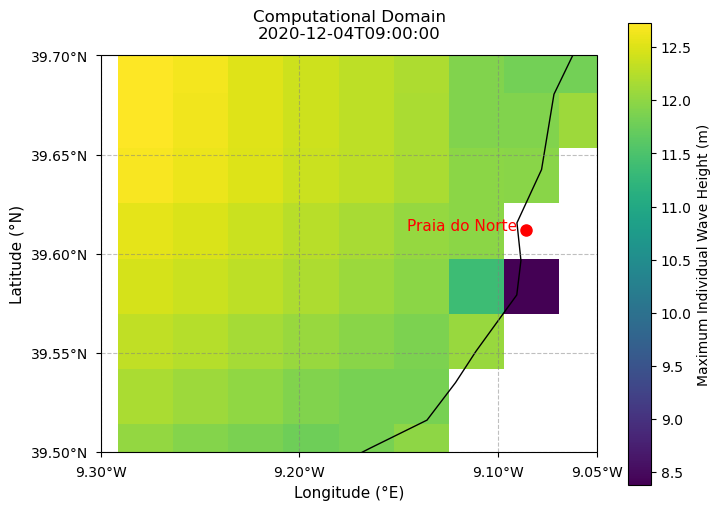

In [76]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker

# Boundaries
lat_min, lat_max = 39.5, 39.7
lon_min, lon_max = -9.3, -9.05
time_slice = "2020-12-04T09:00:00"

# Create figure
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot data
ds["VCMX"].sel(time=time_slice).plot.pcolormesh(
    ax=ax,
    x='longitude',
    y='latitude',
    cmap="viridis",
    shading="auto",
    cbar_kwargs={'label': 'Maximum Individual Wave Height (m)'}
)

# Set extent and title
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.set_title(f"Computational Domain\n{time_slice}", fontsize=12, pad=12)
ax.coastlines()

# Define ticks
xticks = [-9.3, -9.2, -9.1, -9.05]
yticks = [39.5, 39.55, 39.6, 39.65, 39.7]

# Set ticks and format
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter(number_format=".2f", degree_symbol='°'))
ax.yaxis.set_major_formatter(LatitudeFormatter(number_format=".2f", degree_symbol='°'))

# Tick appearance
ax.tick_params(labelsize=10)
ax.tick_params(axis='both', which='major', pad=6)

# Add gridlines
ax.grid(True, which='major', linestyle='--', color='gray', alpha=0.5)

# Plot Praia do Norte
praia_lon = -9.085556
praia_lat = 39.611944
ax.plot(praia_lon, praia_lat, marker='o', color='red', markersize=8, transform=ccrs.PlateCarree())
ax.text(praia_lon - 0.06, praia_lat, "Praia do Norte", color='red', fontsize=11, transform=ccrs.PlateCarree())
ax.set_xlabel("Longitude (°E)", fontsize=11)
ax.set_ylabel("Latitude (°N)", fontsize=11)

# Save figure
plt.savefig("results/methods/computational_domain.png", dpi=300, bbox_inches='tight', pad_inches=0)


### Crop data

In [45]:
# First filter: keep only Jan, Feb, Nov, Dec
months_of_interest = [1, 2, 3, 12]
ds_filtered = ds.sel(time=ds['time'].dt.month.isin(months_of_interest))

In [46]:
print(ds['VCMX'].shape)
print(ds_filtered['VCMX'].shape)
#print(ds['VHM0'].values)

(54049, 8, 9)
(18216, 8, 9)


### Visualize data at Nazare over months of interest

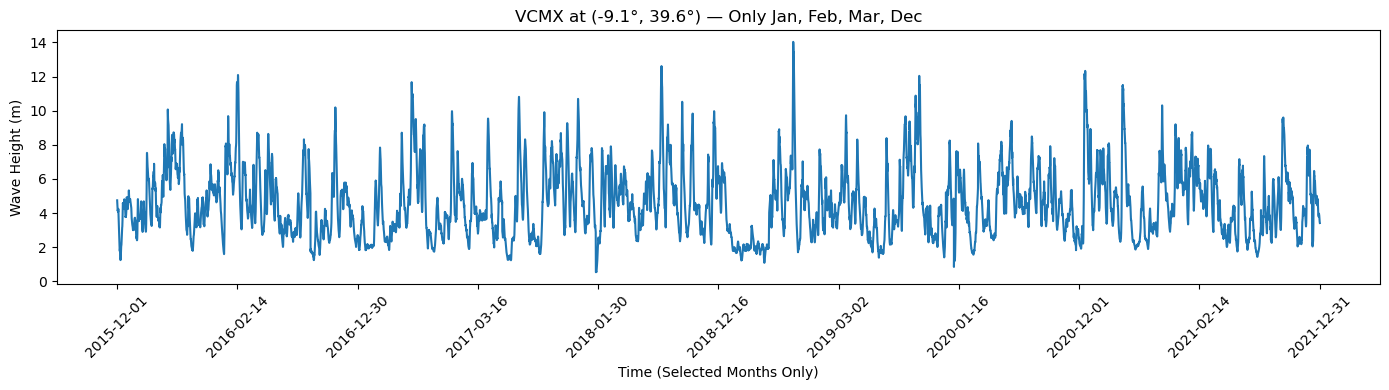

In [47]:
# Filter dataset
point = ds_filtered.sel(latitude=39.6, longitude=-9.1, method="nearest")

# Extract time and data
time_values = pd.to_datetime(point['time'].values)
vc_values = point['VCMX'].values

# Use integer indices for x-axis
x = list(range(len(time_values)))

# Plot
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(x, vc_values, color='tab:blue')

# Custom x-tick labels every N steps (to avoid clutter)
step = len(x) // 10  # show ~10 labels
xticks = x[::step]
xtick_labels = [time.strftime('%Y-%m-%d') for time in time_values[::step]]
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=45)

# Labels
ax.set_title("VCMX at (-9.1°, 39.6°) — Only Jan, Feb, Mar, Dec")
ax.set_ylabel("Wave Height (m)")
ax.set_xlabel("Time (Selected Months Only)")
plt.tight_layout()
plt.show()


## Find big wave events during test period 

In [37]:
# Extract testing period
ds_test = ds_filtered.sel(
    time=slice("2020-12-01", "2021-03-31")
)

point = ds_test.sel(latitude=39.6, longitude=-9.1, method="nearest")

# Access the vcmx variable
vcmx = point['VCMX']  # Adjust if variable name is different

# Resample by week and get the maximum wave height per week (across time, lat, lon)
daily_max = vcmx.resample(time="1D").max()

# Sort by wave height descending and select top 5 weeks
top_days = daily_max.sortby(daily_max, ascending=False).isel(time=slice(0, 10))

# Print week start date and wave height
for t, val in zip(top_days['time'].values, top_days.values):
    print(f"Day {np.datetime_as_string(t, unit='D')}: {float(val):.2f} m")


Day 2020-12-04: 12.33 m
Day 2020-12-05: 12.12 m
Day 2020-12-28: 11.49 m
Day 2020-12-29: 10.69 m
Day 2021-01-22: 10.31 m
Day 2020-12-06: 9.78 m
Day 2021-01-30: 9.20 m
Day 2020-12-08: 8.93 m
Day 2021-01-31: 8.78 m
Day 2021-02-10: 8.74 m


# Part 10

Data type: CMEMS hourly reanalysis data- Atlantic -Iberian Biscay Irish- Ocean Wave Reanalysis

Domain: -9.3; -9.05; 39.5; 39.7

Time: hourly 01/12/2015-31/12/2021

Parameters:

 - sea_surface_wave_maximum_height (VCMX) - m
 - sea_surface_wind_wave_significant_height (VHMO_WW) - m
 - sea_surface_wave_significant_height (VHMO) - m
 - sea_surface_primary_swell_wave_significant_height (VHM0_SW1) - m

In [40]:
### Set working directory
os.chdir('C:/Users/filot/OneDrive - University of Strathclyde/Diss')
ds = xr.open_dataset("data/part10.nc")
print(ds)

<xarray.Dataset> Size: 63MB
Dimensions:    (time: 54049, latitude: 8, longitude: 9)
Coordinates:
  * time       (time) datetime64[ns] 432kB 2015-11-01T23:00:00 ... 2021-12-31...
  * latitude   (latitude) float32 32B 39.5 39.53 39.56 ... 39.64 39.67 39.69
  * longitude  (longitude) float32 36B -9.277 -9.25 -9.222 ... -9.083 -9.055
Data variables:
    VCMX       (time, latitude, longitude) float32 16MB ...
    VHM0_WW    (time, latitude, longitude) float32 16MB ...
    VHM0_SW1   (time, latitude, longitude) float32 16MB ...
    VHM0       (time, latitude, longitude) float32 16MB ...
Attributes:
    Conventions:       CF-1.11
    title:             CMEMS IBI MULTI-YEAR REANALYSIS: HOURLY WAVE PRODUCTS
    institution:       NOWSystems-MeteoFrance
    source:            MFWAM-CY47R1
    contact:           https://marine.copernicus.eu/contact
    references:        http://marine.copernicus.eu/
    comment:           
    subset:source:     ARCO data downloaded from the Marine Data Store usi

### Plot wave height components

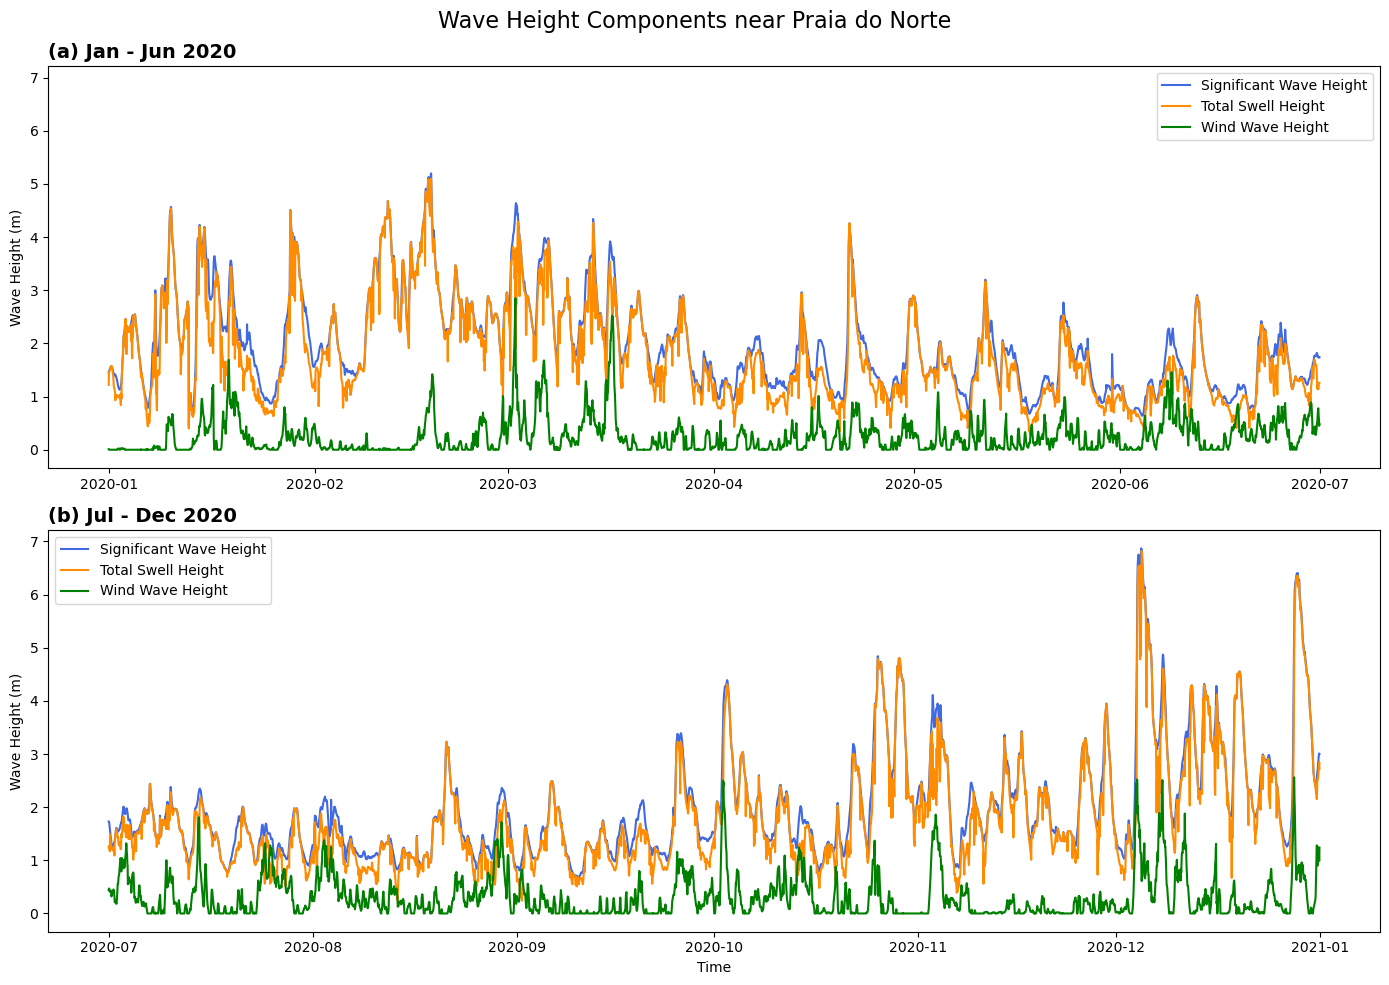

In [89]:
import matplotlib.pyplot as plt

# Select point near Praia do Norte
point = ds.sel(latitude=39.6, longitude=-9.1, method="nearest")

# Create figure and axes for two subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharey=True)

# First subplot: Jan - Jun 2020
point_jan_jun = point.sel(time=slice("2020-01-01", "2020-06-30"))
axes[0].plot(point_jan_jun.time, point_jan_jun['VHM0'], label="Significant Wave Height", color='royalblue')
axes[0].plot(point_jan_jun.time, point_jan_jun['VHM0_SW1'], label="Total Swell Height", color='darkorange')
axes[0].plot(point_jan_jun.time, point_jan_jun['VHM0_WW'], label="Wind Wave Height", color='green')
axes[0].set_title('(a) Jan - Jun 2020', loc='left', fontsize=14, fontweight='bold')
axes[0].set_ylabel("Wave Height (m)")
axes[0].legend()
axes[0].grid(False)

# Second subplot: Jul - Dec 2020
point_jul_dec = point.sel(time=slice("2020-07-01", "2020-12-31"))
axes[1].plot(point_jul_dec.time, point_jul_dec['VHM0'], label="Significant Wave Height", color='royalblue')
axes[1].plot(point_jul_dec.time, point_jul_dec['VHM0_SW1'], label="Total Swell Height", color='darkorange')
axes[1].plot(point_jul_dec.time, point_jul_dec['VHM0_WW'], label="Wind Wave Height", color='green')
axes[1].set_title('(b) Jul - Dec 2020', loc='left', fontsize=14, fontweight='bold')
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Wave Height (m)")
axes[1].legend()
axes[1].grid(False)
# Add main title
fig.suptitle("Wave Height Components near Praia do Norte", fontsize=16)#, fontweight='bold')
plt.tight_layout()
plt.savefig("results/methods/annual_trend.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()


### Plot maximum wave height over 2020

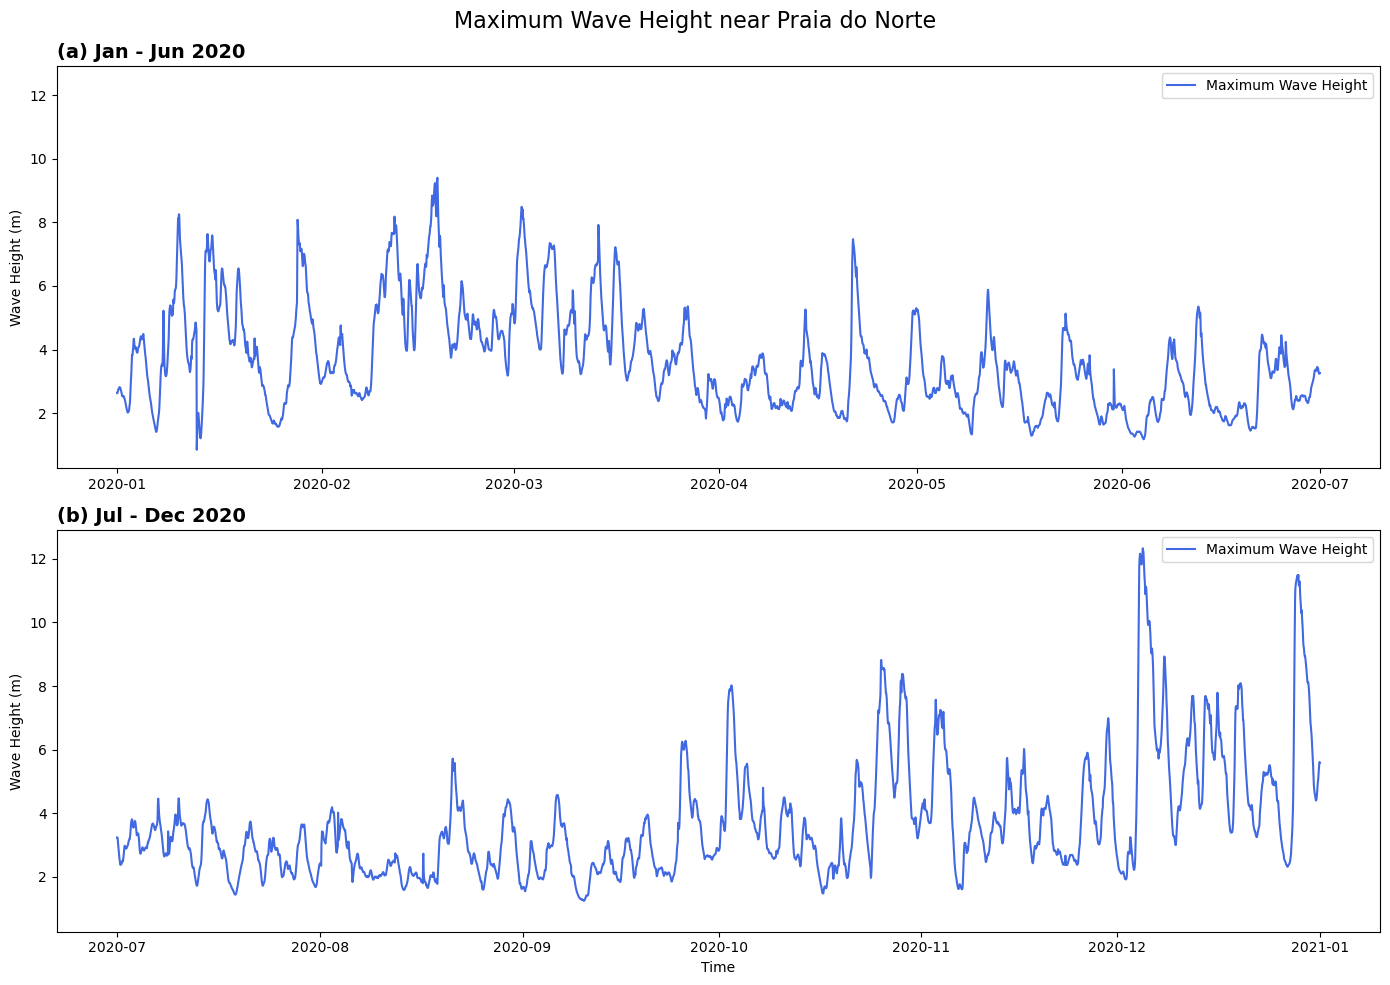

In [91]:
import matplotlib.pyplot as plt

# Select point near Praia do Norte
point = ds.sel(latitude=39.6, longitude=-9.1, method="nearest")

# Create figure and axes for two subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharey=True)

# First subplot: Jan - Jun 2020
point_jan_jun = point.sel(time=slice("2020-01-01", "2020-06-30"))
axes[0].plot(point_jan_jun.time, point_jan_jun['VCMX'], label="Maximum Wave Height", color='royalblue')

axes[0].set_title('(a) Jan - Jun 2020', loc='left', fontsize=14, fontweight='bold')
axes[0].set_ylabel("Wave Height (m)")
axes[0].legend()
axes[0].grid(False)

# Second subplot: Jul - Dec 2020
point_jul_dec = point.sel(time=slice("2020-07-01", "2020-12-31"))
axes[1].plot(point_jul_dec.time, point_jul_dec['VCMX'], label="Maximum Wave Height", color='royalblue')

axes[1].set_title('(b) Jul - Dec 2020', loc='left', fontsize=14, fontweight='bold')
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Wave Height (m)")
axes[1].legend()
axes[1].grid(False)
# Add main title
fig.suptitle("Maximum Wave Height near Praia do Norte", fontsize=16)#, fontweight='bold')
plt.tight_layout()
plt.savefig("results/methods/annual_max_trend.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
